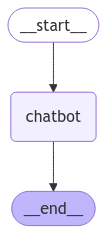

Assistant: 您好！看起来您可能想说些什么，但信息似乎没有完全发送过来。请随时告诉我您需要什么帮助或想要讨论的话题。
Goodbye!


In [4]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

from qwen import qwen_chatmodel


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)



def chatbot(state: State):
    return {"messages": [qwen_chatmodel.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.

graph_builder.add_node("chatbot", chatbot)

graph_builder.add_edge(START, "chatbot")

graph_builder.add_edge("chatbot", END)

graph = graph_builder.compile()

from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break


In [6]:
import os
from langchain_community.tools.tavily_search import TavilySearchResults

os.environ["TAVILY_API_KEY"] = "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"

tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

[{'url': 'https://medium.com/@kbdhunga/beginners-guide-to-langgraph-understanding-state-nodes-and-edges-part-1-897e6114fa48',
  'content': "Beginner’s Guide to LangGraph: Understanding State, Nodes, and Edges — Part 1 | by Kamal Dhungana | Medium Beginner’s Guide to LangGraph: Understanding State, Nodes, and Edges — Part 1 LangGraph — State, Node and Edge Explained Mainly, we will focus on various components of LangGraph: State, Node, and Edges, and how to build a complete graph from these components. Once we understand these components, we will be able to build relatively complex LangGraph-based agents. Each node represents a specific function or operation that processes the current state. Nodes can perform computations, modify the state, or generate outputs based on the input they receive. Follow 1.2K Followers Data scientist with a passion for AI, Regularly blogging about LLM and OpenAI's innovations,Sharing insights for AI community growth Follow"},
 {'url': 'https://blog.langchain

In [ ]:
import json

from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

from langchain_core.messages import ToolMessage

class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

# Modification: tell the LLM which tools it can call
llm_with_tools = qwen_chatmodel.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break
    


In [ ]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

tool = TavilySearchResults(max_results=2)
tools = [tool]
llm_with_tools = qwen_chatmodel.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile(checkpointer=memory)

from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

config = {"configurable": {"thread_id": "1"}}

user_input = "Hi there! My name is Will."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

In [ ]:
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

In [15]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Hi there! My name is Will.', additional_kwargs={}, response_metadata={}, id='c11cb121-b7da-4867-9104-572a31dee1ed'), AIMessage(content="Hello Will! It's nice to meet you. How can I assist you today?", additional_kwargs={}, response_metadata={'model_name': 'qwen-max', 'finish_reason': 'stop', 'request_id': 'dfed9862-7a6d-9b1e-9452-1467c053f12f', 'token_usage': {'input_tokens': 213, 'output_tokens': 17, 'prompt_tokens_details': {'cached_tokens': 0}, 'total_tokens': 230}}, id='run-c2ed1995-036a-49d5-896a-8da0763c587e-0'), HumanMessage(content='Remember my name?', additional_kwargs={}, response_metadata={}, id='8119280a-bfa8-4b34-b138-ce67d7e5b66b'), AIMessage(content='Of course, Will! How can I assist you today?', additional_kwargs={}, response_metadata={'model_name': 'qwen-max', 'finish_reason': 'stop', 'request_id': '2dd3abae-a647-96c5-b86e-449ea6424648', 'token_usage': {'input_tokens': 244, 'output_tokens': 12, 'prompt_tokens_det

In [18]:
from langgraph.types import Command, interrupt

class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


@tool
def human_assistance(query: str) -> str:
    """Request assistance from a human."""
    human_response = interrupt({"query": query})
    return human_response["data"]


tool = TavilySearchResults(max_results=2)
tools = [tool, human_assistance]
llm_with_tools = qwen_chatmodel.bind_tools(tools)


def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    # Because we will be interrupting during tool execution,
    # we disable parallel tool calling to avoid repeating any
    # tool invocations when we resume.
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")


from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

ValidationError: 1 validation error for TavilyInput
  Input should be a valid dictionary or instance of TavilyInput [type=model_type, input_value=<function human_assistance at 0x00000298E5594A40>, input_type=function]
    For further information visit https://errors.pydantic.dev/2.10/v/model_type